# A/B Testing

In [1]:
#Project
#Clickthrough Rates(CTR) and Conversions
#Hypothesis
#H0: Changes on the landing page does not significantly affect conversion rate.
#H1: Changes on the landing page significantly affects conversion rate 

In [2]:
# Importing the  libraries
import numpy as np
import pandas as pd

In [3]:
#Importing the data 
df = pd.read_csv('ab_data.csv')

In [4]:
#Exploring the data,checking the first five cases 
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
#Exploring the data,checking the shape
df.shape

(294478, 5)

In [5]:
# Exploring data consistency and the question is whether there were users in the control group or users in the treatment group who saw the old page.
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [6]:
# The analysis above shows that there was some contamination and so we have to remove control/new_page and treatment/old_page
df_cleaned = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | (df['group'] == 'treatment') & (df['landing_page'] == 'new_page') ]

In [7]:
#We need to confirm that the data clean and ready for analysis
df_cleaned.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [8]:
# We now need to check for duplicate values
df_cleaned['user_id'].duplicated().sum()

1

In [9]:
# There is one record that is duplicated,let us find the user_id for duplicate value
df_cleaned[df_cleaned.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [10]:
#Let us confirm whether the features for these cases are exactly the same 
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
# We are dropping the duplicate values,and again confirming that there are no more duplicate values
df_cleaned = df.drop_duplicates(subset='user_id', keep="first")
df_cleaned['user_id'].duplicated().sum()

0

In [12]:
#Exploring the data further through visualization 
#Importing the library 
import matplotlib.pyplot as plt

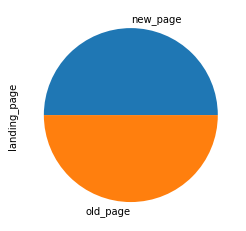

In [13]:
#Visualizing the distribution between the new_page versus the old_page
df['landing_page'].value_counts().plot.pie()

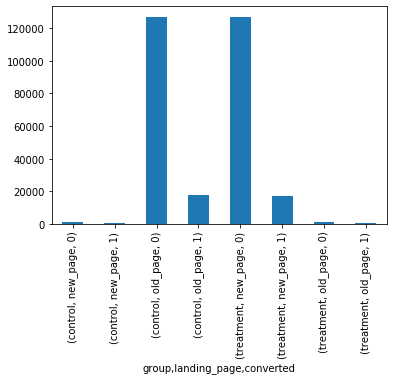

In [14]:
#Visualizing group,landing and converted features
groups = df_cleaned.groupby(['group','landing_page','converted']).size()
groups.plot.bar()

## APPROACH A

In [15]:
# Creating a 2x2 table from the data for purposes of  Chi-Square analysis

# 1) Split groups into two separate DataFrames
a = df[df['group'] == 'control']
b = df[df['group'] == 'treatment']

# 2) A-click, A-noclick, B-click, B-noclick
a_click = a.converted.sum()
a_noclick = a.converted.size - b.converted.sum()
b_click = b.converted.sum()
b_noclick = b.converted.size - b.converted.sum()

# 3) Create np array
T = np.array([[a_click, a_noclick], [b_click, b_noclick]])

In [16]:
#Importing the libraries 
import scipy
from scipy import stats
#Performing Chi-square analysis
print(scipy.stats.chi2_contingency(T,correction=False)[1])

0.2735425174354186


In [ ]:
#The p-value shows thet the landing page did not have significant effect on the conversion rate.
#Therefore,we fail to reject the null hypothesis.

In [27]:
#Checking the probability of conversion in the control and treatment groups respectively 
a_CTR = a_click / (a_click + a_noclick)
b_CTR = b_click / (b_click + b_noclick)
print(a_CTR, b_CTR)

0.12022847684365481 0.11891957956489856


In [28]:
# Prob of conversion regardless of the page
(df.query('converted == 1').converted.count())/df.shape[0]

0.11965919355605512

In [30]:
# Prob of conversion in control group
control_df = df.query('group =="control"')
Pold = control_df['converted'].mean()
Pold

0.12039917935897611

In [33]:
# Prob of conversion in treatment group
treatment_df = df.query('group =="treatment"')
Pnew = treatment_df['converted'].mean()
Pnew

0.11891957956489856

In [34]:
# Prob of receiving new page
df.query('landing_page == "new_page"').landing_page.count()/df.shape[0]

0.5

## APPROACH B

In [18]:
#Regression Approach, we will now perform the test using logistic regression analysis   
df['ab_page'] = pd.get_dummies(df['group']) ['treatment']

In [19]:
#Importing the library 
import statsmodels.api as sm

In [20]:
#We now fit the model and print out the summary,in this case we are thinking of the conversion as the outcome and the feature being the ab_page 
df['intercept'] = 1
logit_mod = sm.Logit(df['converted'],df[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366243
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294476
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Jan 2021   Pseudo R-squ.:               7.093e-06
Time:                        14:34:30   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2161
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9887      0.008   -248.297      0.000      -2.004      -1.973
ab_page       -0.0140      0.011     -1.237      0.216      -0.036       0.008
==============================================================================
"""

In [ ]:
#The p-value shows thet changes on the landing page did not have significant effect on the conversion rate.
#Therefore,we fail to reject the null hypothesis.

In [21]:
#Checking the exponentials
np.exp(results.params)

intercept    0.136879
ab_page      0.986052
dtype: float64

In [24]:
#Checking the logs
1/_

intercept    0.136879
ab_page      0.986052
dtype: float64